In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import numpy as np
import matplotlib.pyplot as plt
from os.path import join

import astropy
from astropy.io import fits
import h5py
import pandas as pd


In [2]:
os.chdir('/home/mattho/git/ltu-connect/sdss_mgs')
os.listdir()

['explore_mgs.ipynb',
 'README.txt',
 'tools.py',
 '__pycache__',
 'test_camels_to_mgs.ipynb',
 'tutorial_mock_mgs.ipynb',
 'centrals.png']

## Load Austen's CAMELS-SAM dataset

In [3]:
ddir = '/home/mattho/git/ltu-connect/camels_data/samout'
bid = (0,0,0)
os.listdir(join(ddir, '_'.join(map(str, bid))))

['files.list',
 'param.scsam',
 'progress.log',
 'tree_offsets.hdf5',
 'subvolume.hdf5']

In [4]:
# Cosmology (from param.scsam)
Omega_m = 0.3089
Omega_lambda = 0.6911
h = 0.6774
Omega_b = Omega_m*0.1573

# in quijote format [Omega_m, Omega_b, h, n_s, sigma8]
cosmo = np.array([Omega_m, Omega_b, h, None, None])

In [5]:
# Load CAMELS-SAM

subsample = 0.005  # fraction of galaxies to use, to speed up
gpos = []
gvel = []
Lbox = 100/h  # Mpc

for idx in np.array(np.meshgrid(*[[0,1]]*3)).reshape(3,-1).T:
    print(idx)
    with h5py.File(join(ddir, '_'.join(map(str, idx)), 'subvolume.hdf5'), 'r') as f:
        # print('\n'.join(list(f['Galprop'].keys())))
        mask = np.random.rand(f['Galprop']['GalpropPos'].shape[0]) < subsample
        pos = f['Galprop']['GalpropPos'][mask] % Lbox # Mpc
        vel = f['Galprop']['GalpropVel'][mask]       # km/s
        gpos.append(pos)
        gvel.append(vel)

gpos = np.concatenate(gpos)
gvel = np.concatenate(gvel)

gpos = gpos * h  # Mpc/h

[0 0 0]
[0 0 1]
[1 0 0]
[1 0 1]
[0 1 0]
[0 1 1]
[1 1 0]
[1 1 1]


(0.0, 100.0)

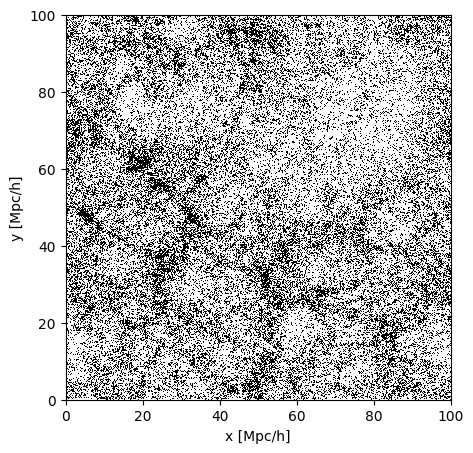

In [6]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(gpos[:,0], gpos[:,1], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

## Load NYU-VAGC footprint

In [7]:
odir = '/home/mattho/git/ltu-connect/MGS'

# Load Tjitske's data
cols = ['RA', 'DEC', 'Z', 'MAG', 'SURVEY', 'ZSRC']
with h5py.File(join(odir, 'tinker_SDSS_centrals_M9.7.valueadd.hdf5'), 'r') as f:
    datatj = pd.DataFrame([f[col] for col in cols], index=cols).T


# Restrict angular range
rae = 100, 270
dece = 0, 70
ze = 0.01, 0.0335
mask = (datatj['RA'] > rae[0]) & (datatj['RA'] < rae[1])
mask &= (datatj['DEC'] > dece[0]) & (datatj['DEC'] < dece[1])
mask &= (datatj['Z'] > ze[0]) & (datatj['Z'] < ze[1])
datatj = datatj[mask]


# Label quadrants
ramid = 187
decmid = 30

def label_quadrants(dat):
    bins = np.zeros(len(dat))
    mask = (dat['RA']<ramid) & (dat['DEC']<decmid)
    bins[mask] = 0
    mask = (dat['RA']<ramid) & (dat['DEC']>decmid)
    bins[mask] = 1
    mask = (dat['RA']>ramid) & (dat['DEC']<decmid)
    bins[mask] = 2
    mask = (dat['RA']>ramid) & (dat['DEC']>decmid)
    bins[mask] = 3
    return bins

datatj['bin'] = label_quadrants(datatj)

Text(0.5, 0, 'Z')

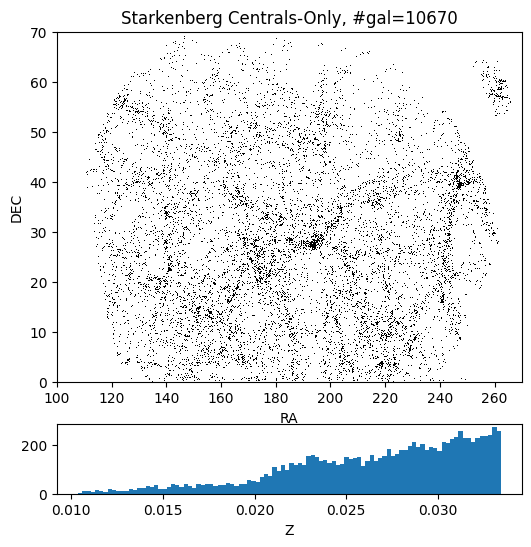

In [8]:
f, axs = plt.subplots(2, 1, figsize=(6, 6),
                      gridspec_kw={'height_ratios': [1, 0.2]})

# tjitske
ax = axs[0]
ax.plot(datatj['RA'], datatj['DEC'], 'k,', alpha=1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Starkenberg Centrals-Only, #gal={len(datatj)}')

ax = axs[1]
ax.hist(datatj['Z'], bins=100)
ax.set_xlabel('Z')

## Plot full footprint

In [9]:
from tools import sky_to_xyz, xyz_to_sky

# Load full footprint
ordz = np.stack([
    datatj['RA'].values,
    datatj['DEC'].values,
    datatj['Z'].values
], axis=1).astype(np.float64)

oxyz = sky_to_xyz(ordz, cosmo)

In [10]:
# median ra, dec, z
med_rdz = np.median(ordz, axis=0)
med_xyz = sky_to_xyz(med_rdz, cosmo)

# dmedian/dra
med1_rdz = med_rdz + [0.01,0,0]
med1_xyz = sky_to_xyz(med1_rdz, cosmo)

from scipy.spatial.transform import Rotation as R

# calculate x-axis vector
xvec = med1_xyz - med_xyz
xvec /= np.linalg.norm(xvec)
mvec = med_xyz / np.linalg.norm(med_xyz)

# rotate med to z
rotz_axis = np.cross(mvec, [0,0,1])
rotz_axis /= np.linalg.norm(rotz_axis)
rotz_angle = np.arccos(np.dot(mvec, [0,0,1]))
rotz = R.from_rotvec(rotz_angle*rotz_axis)

# rotate med1 to x
xvec = rotz.apply(xvec)
rotx_angle = -np.arctan2(xvec[1], xvec[0])
rotx = R.from_rotvec(rotx_angle*np.array([0,0,1]))

In [11]:
zoxyz = rotz.apply(oxyz)
zoxyz = rotx.apply(zoxyz)

[Text(0.5, 0, 'z [Mpc/h]'),
 Text(0, 0.5, 'y [Mpc/h]'),
 Text(0.5, 1.0, 'Side-on')]

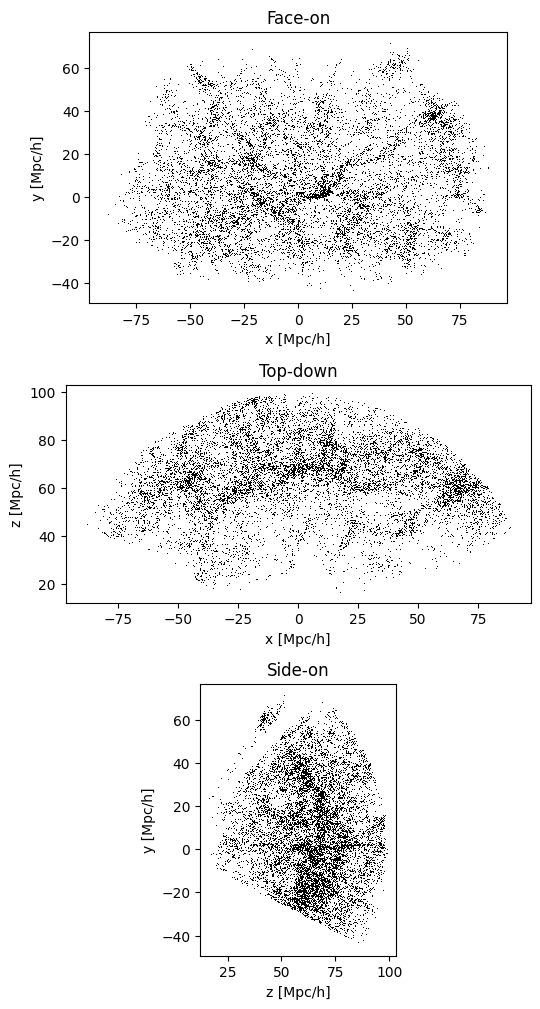

In [12]:
f, axs = plt.subplots(3, 1, figsize=(6, 12))

ax = axs[0]
ax.plot(zoxyz[:,0], zoxyz[:,1], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]', title='Face-on')

ax = axs[1]
ax.plot(zoxyz[:,0], zoxyz[:,2], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='z [Mpc/h]', title='Top-down')

ax = axs[2]
ax.plot(zoxyz[:,2], zoxyz[:,1], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='z [Mpc/h]', ylabel='y [Mpc/h]', title='Side-on')

In [13]:
# get comoving ranges
ranges = np.stack([np.min(zoxyz, axis=0), np.max(zoxyz, axis=0)])
mids = np.mean(ranges, axis=0)
vol = np.prod(ranges[1] - ranges[0])
print(f'Volume=({vol**(1/3):.4f} Mpc/h)^3')
for i in range(3):
    print(f'{i}: {np.diff(ranges[:,i])[0]:.3f} Mpc/h')

Volume=(118.5814 Mpc/h)^3
0: 176.062 Mpc/h
1: 114.508 Mpc/h
2: 82.708 Mpc/h


## Match Q1

In [32]:
# load Q1
mask = datatj['bin'] == 0
ordz = np.stack([
    datatj['RA'].values[mask],
    datatj['DEC'].values[mask],
    datatj['Z'].values[mask]
], axis=1).astype(np.float64)

# convert radecz to xyz
oxyz = sky_to_xyz(ordz, cosmo)

In [15]:
# calculate rotation matrix to align median to z
from tools import rotate_to_z

# median ra, dec, z, to be rotated to z-axis
med_rdz = np.median(ordz, axis=0)

# rotation and inverse rotation matrices
rot, irot = rotate_to_z(med_rdz, cosmo)

In [16]:
# rotate to face-on
zoxyz = rot.apply(oxyz)

[Text(0.5, 0, 'z [Mpc/h]'),
 Text(0, 0.5, 'y [Mpc/h]'),
 Text(0.5, 1.0, 'Side-on')]

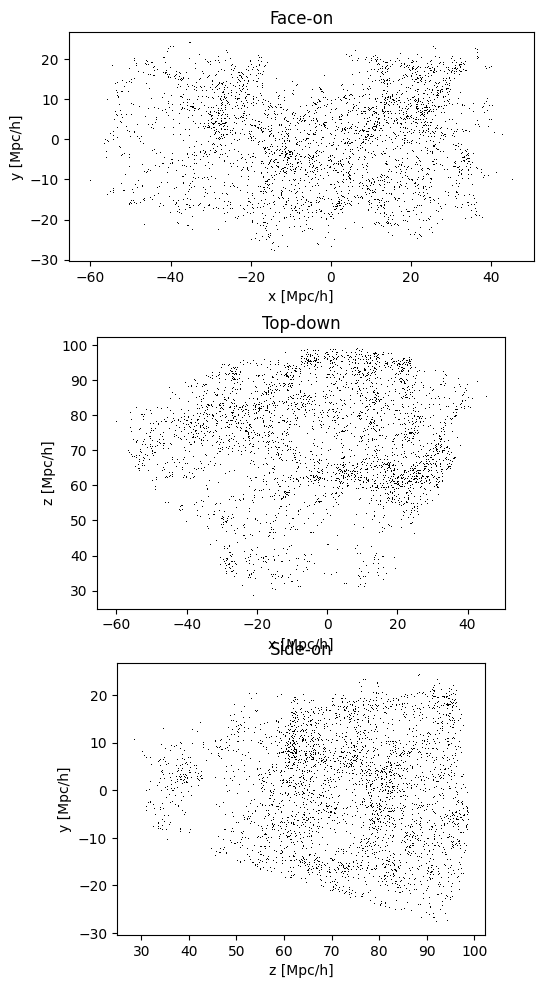

In [17]:
f, axs = plt.subplots(3, 1, figsize=(6, 12))

ax = axs[0]
ax.plot(zoxyz[:,0], zoxyz[:,1], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]', title='Face-on')

ax = axs[1]
ax.plot(zoxyz[:,0], zoxyz[:,2], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='z [Mpc/h]', title='Top-down')

ax = axs[2]
ax.plot(zoxyz[:,2], zoxyz[:,1], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='z [Mpc/h]', ylabel='y [Mpc/h]', title='Side-on')

In [18]:
# get comoving ranges
ranges = np.stack([np.min(zoxyz, axis=0), np.max(zoxyz, axis=0)])
mids = np.mean(ranges, axis=0)
vol = np.prod(ranges[1] - ranges[0])
print(f'Volume=({vol**(1/3):.4f} Mpc/h)^3')
for i in range(3):
    print(f'{i}: {np.diff(ranges[:,i])[0]:.3f} Mpc/h')

Volume=(72.8006 Mpc/h)^3
0: 105.554 Mpc/h
1: 51.952 Mpc/h
2: 70.360 Mpc/h


In [19]:
# check remap geometry

import cuboid_remap as cremap

# Desired geometry
geometry = np.diff(ranges, axis=0)/100 # Mpc/h

# Generate all possible lattice vectors with integer components less than or equal to 1
latvecs = cremap.generate_lattice_vectors(max_int=1)

# Print the possible cuboid side lengths
print("Possible cuboid side lengths:")
for key in latvecs.keys():
    print(f"{key}")

# Find one which encompasses the desired geometry
print('\nSatisfactory cuboid configuration:')
for key in latvecs.keys():
    if np.all(np.sort(key) >= np.sort(geometry)):
        break
    break
target_geometry = np.array(key)*100  # Mpc/h
target_geometry[[1,2]] = target_geometry[[2,1]]
print(f"target_geometry = {target_geometry}")

u1, u2, u3 = latvecs[key][0]
print(f"u1 = {u1}")
print(f"u2 = {u2}")
print(f"u3 = {u3}")

Possible cuboid side lengths:
(1.7320508075688772, 0.816496580927726, 0.7071067811865475)
(1.7320508075688772, 0.816496580927726, 0.7071067811865476)
(1.7320508075688772, 1.4142135623730951, 0.408248290463863)
(1.4142135623730951, 1.0, 0.7071067811865476)
(1.4142135623730951, 1.224744871391589, 0.5773502691896258)
(1.4142135623730951, 1.224744871391589, 0.5773502691896257)
(1.0, 1.0, 1.0)

Satisfactory cuboid configuration:
target_geometry = [173.20508076  70.71067812  81.64965809]
u1 = [-1 -1 -1]
u2 = [-1 -1  0]
u3 = [-1  0 -1]


[Text(0.5, 0, 'z [Mpc/h]'),
 Text(0, 0.5, 'y [Mpc/h]'),
 Text(0.5, 1.0, 'Side-on')]

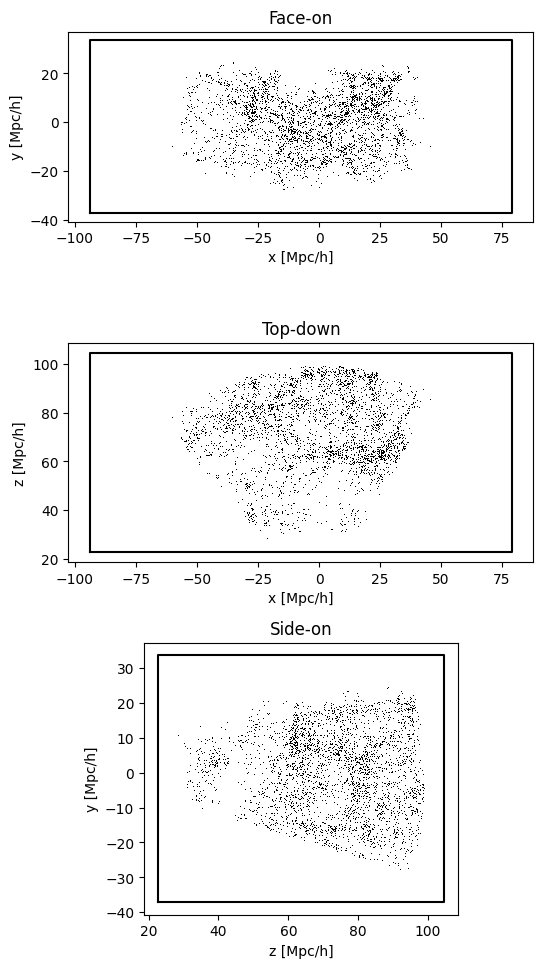

In [20]:
def plot_rectangle(x, y, Lx, Ly, ax, c='k'):
    ax.plot([x-Lx/2, x+Lx/2, x+Lx/2, x-Lx/2, x-Lx/2], 
            [y-Ly/2, y-Ly/2, y+Ly/2, y+Ly/2, y-Ly/2], 
            c=c)

f, axs = plt.subplots(3, 1, figsize=(6, 12))

ax = axs[0]
ax.plot(zoxyz[:,0], zoxyz[:,1], 'k,', alpha=1)
plot_rectangle(mids[0], mids[1], target_geometry[0], target_geometry[1], ax)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]', title='Face-on')

ax = axs[1]
ax.plot(zoxyz[:,0], zoxyz[:,2], 'k,', alpha=1)
plot_rectangle(mids[0], mids[2], target_geometry[0], target_geometry[2], ax)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='z [Mpc/h]', title='Top-down')

ax = axs[2]
ax.plot(zoxyz[:,2], zoxyz[:,1], 'k,', alpha=1)
plot_rectangle(mids[2], mids[1], target_geometry[2], target_geometry[1], ax)
ax.set_aspect('equal')
ax.set(xlabel='z [Mpc/h]', ylabel='y [Mpc/h]', title='Side-on')

#### Add CAMELS data

In [21]:
import jax
C = cremap.Cuboid(u1=u1, u2=u2, u3=u3)
Lbox = 100  # Mpc/h

transform = jax.vmap(C.Transform, in_axes=0)
gposT = transform(gpos/Lbox)*Lbox
gposT -= np.mean(gposT, axis=0)
gposT += mids
gvelT = C.TransformVelocity(gvel)

/data80/mattho/anaconda3/envs/connect/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)


In [22]:
mids

array([-7.42323088, -1.79485506, 63.59001351])

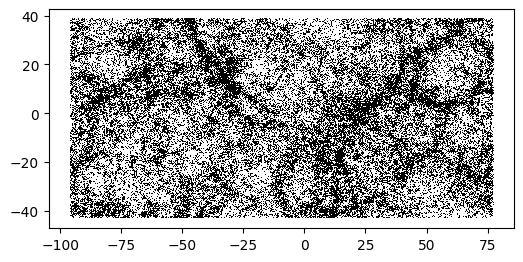

In [23]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(gposT[:, 0], gposT[:,1], 'k,', alpha=1)
ax.set_aspect('equal')

In [24]:
gxyz = irot.apply(gposT)
gvel = irot.apply(gvelT.T)

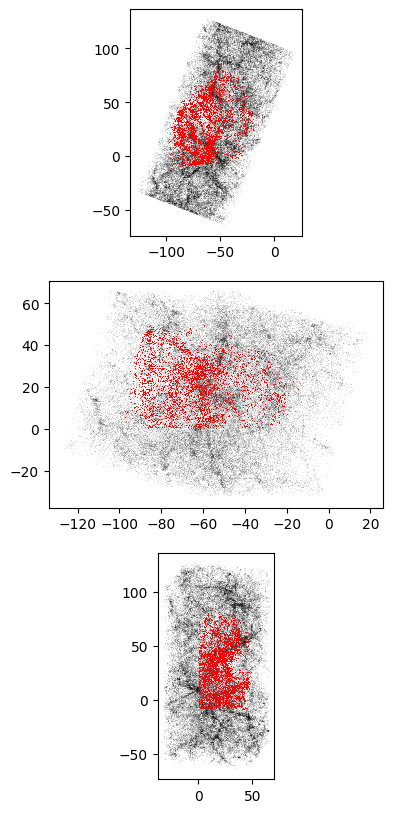

In [25]:
f, axs = plt.subplots(3, 1, figsize=(10, 10))

ax = axs[0]
ax.plot(gxyz[:, 0], gxyz[:,1], 'k,', alpha=0.1)
ax.plot(oxyz[:, 0], oxyz[:,1], 'r,', alpha=1)
ax.set_aspect('equal')

ax = axs[1]
ax.plot(gxyz[:, 0], gxyz[:,2], 'k,', alpha=0.1)
ax.plot(oxyz[:, 0], oxyz[:,2], 'r,', alpha=1)
ax.set_aspect('equal')

ax = axs[2]
ax.plot(gxyz[:, 2], gxyz[:,1], 'k,', alpha=0.1)
ax.plot(oxyz[:, 2], oxyz[:,1], 'r,', alpha=1)
ax.set_aspect('equal')

In [30]:
grdz = xyz_to_sky(gxyz, gvel, cosmo)

mask = (grdz[:,0] > rae[0]) & (grdz[:,0] < rae[1])
mask &= (grdz[:,1] > dece[0]) & (grdz[:,1] < dece[1])
mask &= (grdz[:,2] > ze[0]) & (grdz[:,2] < ze[1])
mask &= (grdz[:,0] < ramid) & (grdz[:,1] < decmid)
grdz = grdz[mask]

Text(0.5, 0, 'Z')

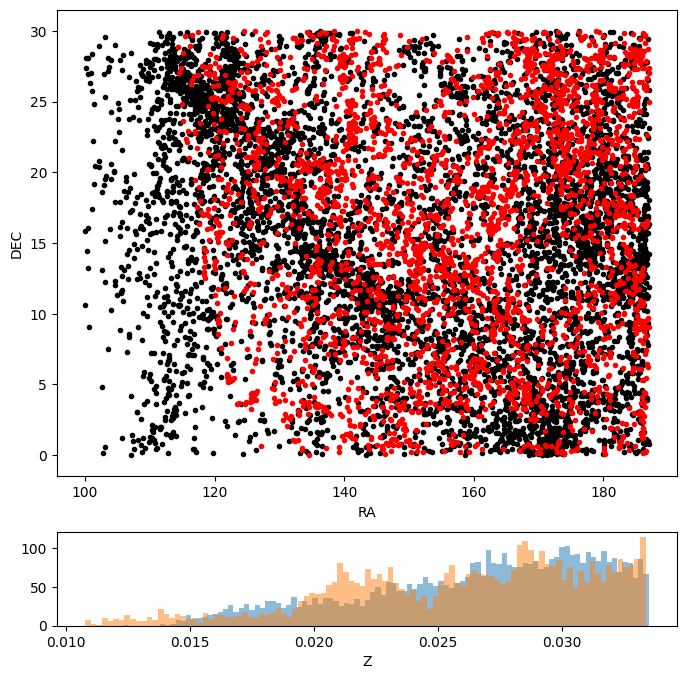

In [34]:
f, axs = plt.subplots(2, 1, figsize=(8, 8), 
                      gridspec_kw={'height_ratios': [1, 0.2]})

ax = axs[0]
ax.plot(grdz[:, 0], grdz[:,1], 'k.', alpha=1)
ax.plot(ordz[:, 0], ordz[:,1], 'r.', alpha=1)
ax.set(xlabel='RA', ylabel='DEC')

ax = axs[1]
ax.hist(grdz[:,2], bins=100, alpha=0.5, density=True)
ax.hist(ordz[:,2], bins=100, alpha=0.5, density=True)
ax.set_xlabel('Z')

In [39]:
import pymangle
f_poly = join(odir, 'tmp_lss_geometry.ply')
mask = pymangle.Mangle(f_poly)

w = mask.weight(grdz[:,0], grdz[:,1])


In [48]:
mask = w > 0

Text(0.5, 0.98, 'CAMELS-SAM vs NYU-VAGC centrals - Quadrant 0')

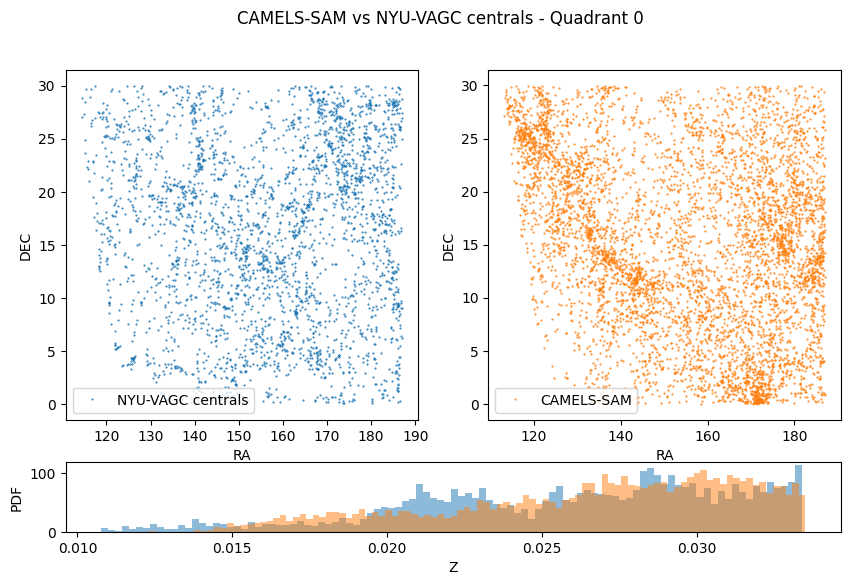

In [56]:
f = plt.figure(figsize=(10, 6))
gs = f.add_gridspec(2, 2, height_ratios=[1, 0.2])

ax = f.add_subplot(gs[0,0])
ax.plot(ordz[:, 0], ordz[:,1], '.', c='C0', alpha=1, ms=1, label='NYU-VAGC centrals')
ax.set(xlabel='RA', ylabel='DEC')
ax.legend()

ax = f.add_subplot(gs[0,1])
ax.plot(grdz[mask, 0], grdz[mask,1], '.', c='C1', alpha=1, ms=1, label='CAMELS-SAM')
ax.set(xlabel='RA', ylabel='DEC')
ax.legend()

ax = f.add_subplot(gs[1,:])
ax.hist(ordz[:,2], bins=100, alpha=0.5, density=True)
ax.hist(grdz[mask,2], bins=100, alpha=0.5, density=True)
ax.set_xlabel('Z')
ax.set_ylabel('PDF')

f.suptitle('CAMELS-SAM vs NYU-VAGC centrals - Quadrant 0')

## Measure median rdz for all quadrants

In [28]:

from tools import rotate_to_z
medlist = []
midlist = []
for i in range(4):
    print(f'Q{i}')

    # load Qi
    mask = datatj['bin'] == i
    ordz = np.stack([
        datatj['RA'].values[mask],
        datatj['DEC'].values[mask],
        datatj['Z'].values[mask]
    ], axis=1).astype(np.float64)

    # convert radecz to xyz
    oxyz = sky_to_xyz(ordz, cosmo)

    # calculate median
    med_rdz = np.median(ordz, axis=0)

    # median ra, dec, z, to be rotated to z-axis
    med_rdz = np.median(ordz, axis=0)

    # rotation and inverse rotation matrices
    rot, irot = rotate_to_z(med_rdz, cosmo)

    # rotate to face-on
    zoxyz = rot.apply(oxyz)

    # calculate mids
    ranges = np.stack([np.min(zoxyz, axis=0), np.max(zoxyz, axis=0)])
    mids = np.mean(ranges, axis=0)

    medlist.append(list(med_rdz))
    midlist.append(list(mids))

medlist, midlist

Q0
Q1
Q2
Q3


([[158.74303878318312, 17.031270102890435, 0.026811392977833748],
  [153.8592001343185, 44.158932963996975, 0.026938676834106445],
  [216.71722613494188, 16.329543211502916, 0.027733768336474895],
  [222.9051448119211, 40.377727202747, 0.02919937949627638]],
 [[-7.423230881631724, -1.7948550618949621, 63.590013506439035],
  [-1.3064032063107227, 9.825968802370923, 63.63458562404868],
  [5.699150317635436, -0.32144799152813697, 63.56326396869353],
  [0.30577017327591705, 13.15838995467428, 63.762795256487166]])